In [1]:
!wandb login

wandb: Currently logged in as: dannovikov. Use `wandb login --relogin` to force relogin


In [2]:
import wandb

In [3]:
wandb.init(project="seq lin autoencoder")

wandb: Currently logged in as: dannovikov. Use `wandb login --relogin` to force relogin


In [4]:
import os
os.getcwd()

'E:\\projects\\seqpredict'

In [5]:
#This program trains an Autoencoder to reconstruct DNA sequences.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

EPOCHS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


cuda


In [6]:

class SequenceAutoencoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            #nn.Conv1d(in_channels=5, out_channels=1, kernel_size=1),
            #nn.ReLU(),
            nn.Linear(29903, 2500),
            nn.ReLU(),
            nn.Linear(2500, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 2500),
            nn.ReLU(),
            nn.Linear(2500, 29903),
            #nn.ConvTranspose1d(in_channels=1, out_channels=5, kernel_size=1),
            #nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # x = torch.argmax(x, dim = 1)
        return x


def create_seqs_dict(fasta):
    """
    From a fasta file, the function builds a dictionary {label:sequence}.
    In fasta format, the even # lines are labels that start with ">",
    the odd # lines are sequences.
    """
    seqs = {}
    with open(fasta, "r") as f:
        last_label = ""
        for line, text in enumerate(f):
            if line % 2 == 0:  # is label
                # Create new entry in dictionary for upcoming sequence
                seqs[text.strip()[1:]] = ""
                last_label = text.strip()[1:]
            else:
                # Add sequence to newly created entry
                seqs[last_label] = text.strip()
    return seqs


def create_seqs_matrix(seqs, SEQ_LEN):
    """
    ONE-HOT ENCODING
    seqs is a dict mapping id:sequence
    return N x M x 5 tensor where each row is a M x 5 one-hot encoding of an M-length sequence
    """
    seqs_m = np.zeros(shape=(len(seqs), SEQ_LEN, 5))
    seqs_index = {}
    # for i, seq_id in enumerate(tqdm(seqs)):
    for i, seq_id in enumerate(seqs):
        seqs_index[seq_id] = i
        for j, raw_nucl in enumerate(seqs[seq_id]):
            nucl = raw_nucl.upper()
            if nucl == "A":
                seqs_m[i][j][0] = 1
            elif nucl == "C":
                seqs_m[i][j][1] = 1
            elif nucl == "T":
                seqs_m[i][j][2] = 1
            elif nucl == "G":
                seqs_m[i][j][3] = 1
            else:
                assert nucl == "-" or nucl == "N", f"nucl: {nucl}"
                seqs_m[i][j][4] = 1
    return seqs_m, seqs_index


In [7]:
def hamdist(a, b):
    d = 0
    for i in range(len(a)):
        if a[i] != 'N' and b[i] != 'N':
            if a[i] != b[i]:
                d += 1
    return d

In [8]:
def argmax_to_actg(am_seq):
    out_seq = ''
    for i in range(am_seq.shape[0]):
        x = am_seq[i]
        if x == 0:
            out_seq += 'A'
        elif x == 1:
            out_seq += 'C'
        elif x == 2:
            out_seq += 'T'
        elif x == 3:
            out_seq += 'G'
        else:
            assert x == 4
            out_seq += 'N'
    return out_seq

In [9]:
def ohe_to_actg(ohe_seq):
    #seq shape = 1, L, 5
    #for each nucl vector in L
    #convert nucl vector to corresponding nucl
    seq = ''
    for i in range(ohe_seq.shape[0]):
        nucl = ohe_seq[i]
        if nucl[0] == 1:
            seq += 'A'
        elif nucl[1] == 1:
            seq += 'C'
        elif nucl[2] == 1:
            seq += 'T'
        elif nucl[3] == 1:
            seq += 'G'
        else:
            assert nucl[4] == 1
            seq += 'N'
    return seq


In [10]:

def HammingDistanceMetric(batch, out):
    assert batch.shape == out.shape
    distance = 0
    for i in range(batch.shape[0]):
        input, output = batch[i], out[i]
        input = ohe_to_actg(input.permute(1,0))
        output = argmax_to_actg(torch.argmax(output.permute(1,0), dim=1))
        distance += hamdist(input, output)
    return distance / batch.shape[0]



BEGIN


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

model saved with  1.0283179046078161 loss on epoch 0


  0%|          | 0/352 [00:00<?, ?it/s]

model saved with  0.42330769974399696 loss on epoch 1
[1.4730634195048635, 0.7168599857789714]
[1.0283179046078161, 0.42330769974399696]


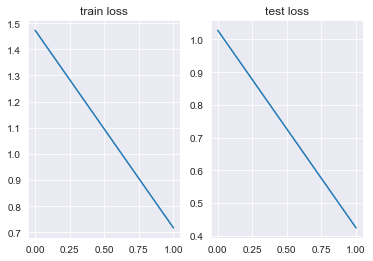

In [11]:

if __name__ == '__main__':

    fasta_file = 'f22_n.fasta'

    seqs_d = create_seqs_dict(fasta_file)
    # print('created seqs dict', flush=True)
    seq_len = len(seqs_d[list(seqs_d.keys())[0]])
    seqs_m, seqs_index = create_seqs_matrix(seqs_d, SEQ_LEN=seq_len) # one-hot encoding
    # print('done - seqs matrix', flush=True)
    seqs_t = torch.from_numpy(seqs_m).float()
    # print('done - seqs tensor', flush=True)
    del seqs_m
    del seqs_index
    del seqs_d
    # print('previous variables deleted', flush=True)
    seqs_t = seqs_t.permute(0,2,1)
    seqs_ds = torch.utils.data.TensorDataset(seqs_t)
    del seqs_t
    # print('tensor dataset created and seqs_t deleted')
    #
    N = len(seqs_ds)
    train_ds, test_ds = torch.utils.data.random_split(seqs_ds, [int(0.7*N), N - int(0.7*N)], generator=torch.Generator().manual_seed(42))
    # print('random split done', flush=True)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True,pin_memory=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False,pin_memory=True)
    # print('created data loaders', flush=True)


    model = SequenceAutoencoder()
    #model.load_state_dict(torch.load('linseqae.m'))
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, verbose=True, factor=0.1, threshold=0.01)

    model.to(DEVICE)

    min_loss = float('inf')
    trl = [] #training losses
    tsl = [] #testing losses
    tshd = [] #testing hamming distances
    print('BEGIN', flush=True)
    for epoch in tqdm(range(EPOCHS)):
        train_losses = []
        val_losses = []
        val_hamdists = []
        # train
        for idx, batch in enumerate(train_dl):
            # seq = torch.tensor(batch[0])
            seq = batch[0]
            seq = seq.to(DEVICE)
            optimizer.zero_grad()
            out = model(seq)
            loss = criterion(out, seq)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        # validate
        with torch.no_grad():
            for idx,batch in enumerate(test_dl):
                # seq = torch.tensor(batch[0])
                seq = batch[0]
                seq = seq.to(DEVICE)
                out = model(seq)
                loss = criterion(out, seq)
                val_losses.append(loss.item())
                #val_hamdists.append(HammingDistanceMetric(seq, out))
        # Collect resultsS
        trl.append(sum(train_losses)/len(train_dl))
        tsl.append(sum(val_losses)/len(test_dl))
        #tshd.append(sum(val_hamdists)/len(test_dl))
        wandb.log({'train_loss': trl[-1], 'test_loss': tsl[-1]})#, 'test_hamming': tshd[-1]})
        scheduler.step(tsl[-1])
        # save best model
        if tsl[-1] < min_loss:
            min_loss = tsl[-1]
            print('model saved with ', min_loss, 'loss on epoch', epoch,flush=True)
            torch.save(model.state_dict(), './linseqae.m')


    print(trl)
    print(tsl)
    fig, axs = plt.subplots(1,2)
    plt.title('train_loss')
    axs[0].plot(trl)
    axs[0].set_title('train loss')
    axs[1].plot(tsl)
    axs[1].set_title('test loss')



In [12]:
test = next(iter(test_dl))[0]

In [13]:
test = test.to(DEVICE)
out = model(test)

In [14]:
out.shape

torch.Size([1, 5, 29903])

In [15]:
test = test.permute(0,2,1)
test.shape

torch.Size([1, 29903, 5])

In [16]:
x = ohe_to_actg(test)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
len(x)

In [ ]:
out = out.cpu()
out = out.permute(0, 2, 1)

In [ ]:
out.shape

In [ ]:
out = torch.argmax(out, dim=2)

In [ ]:
len(out[0])

In [ ]:
out

In [ ]:
x

In [ ]:
y = argmax_to_actg(out)

In [ ]:
y

In [ ]:
f"Autoencoding Hamming distance: {hamdist(x, y)}/29903"

In [ ]:
#Just linear and relu layers give us nice sequences!

In [ ]:
#omg

In [ ]:
#That's a nice looking sequence reconstruction